Run `pip install .` first to install all dependencies.

In [1]:
!pip install gcsfs==2022.10.0
!pip install google-auth==2.15.0
!pip install psutil==5.9.4
!pip install wandb
!pip install fastparquet
!pip install numpy
!pip install pandas
!pip install catboost
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
  Using cached gcsfs-2022.10.0-py2.py3-none-any.whl (25 kB)
  Using cached fsspec-2022.10.0-py3-none-any.whl (138 kB)
  Using cached google_cloud_storage-2.7.0-py2.py3-none-any.whl (110 kB)
  Using cached google_auth_oauthlib-0.8.0-py2.py3-none-any.whl (19 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Using cached google_resumable_media-2.4.0-py2.py3-none-any.whl (77 kB)
  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)
  Using cached protobuf-4.21.12-cp37-abi3-manylinux2014_x86_64.whl (409 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 KB 10.5 MB/s eta 0:00:00
  Using cached google_crc32c-1.5.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32 kB)
ERROR: Will not install to the user site because it will lack sys.path precedence to fsspec in /pfs/data5/software_uc2/bwhpc/common

In [2]:
import os

from catboost import CatBoostClassifier, Pool
import numpy as np

import gcsfs
import numpy as np
import pandas as pd

import wandb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import NotFittedError

from scipy import stats

In [3]:
# # connect to weights and biases
# run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")


In [4]:
# import google.auth
# from google.colab import auth
# # connect to google cloud storage
# auth.authenticate_user()
# credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis")
#fs = gcsfs.GCSFileSystem(project="thesis", credentials=credentials)

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
# reduce number of imported cols due to memory issues
columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]


In [31]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
)#.sample(frac=0.1)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
)#.sample(frac=0.1)

In [32]:
from sklearn.preprocessing import PowerTransformer

In [33]:
train.head()

,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,price_ex_lead,price_ex_lag,buy_sell
0,2005-05-02 09:30:02,YNU,2006-01-21,2.5,C,10,2.05,1.9,2.10,2.10,1.90,131.0,20.0,1.90,1.90,1.90,2.10,1
1,2005-05-02 09:30:03,SYQ,2005-06-18,15.0,C,10,3.90,3.6,3.80,NaN,NaN,NaN,NaN,4.00,4.00,4.60,4.00,1
2,2005-05-02 09:30:03,SWG,2005-05-21,105.0,C,50,11.20,11.1,11.40,11.40,11.10,300.0,300.0,11.80,11.00,11.90,11.00,-1
3,2005-05-02 09:30:03,QAX,2005-06-18,25.0,C,10,0.20,0.0,0.25,0.25,0.00,0.0,86.0,0.15,0.15,0.15,0.15,1
4,2005-05-02 09:30:03,ORQ,2005-12-17,14.0,C,15,0.25,0.3,0.40,0.45,0.25,3356.0,399.0,0.35,0.35,0.35,0.35,-1


In [34]:
num_features = [
    "STRK_PRC",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "day_vol", 
    "myn"
]

## Yeo Johnson test

In [35]:
yeo_johnson = PowerTransformer(method="yeo-johnson")
yeo_johnson.fit(train[num_features])

PowerTransformer()

In [36]:
lambdas = pd.Series(data=yeo_johnson.lambdas_, index=num_features)
lambdas

STRK_PRC         -0.126414
TRADE_SIZE       -0.379786
TRADE_PRICE      -0.446928
BEST_BID         -0.442183
BEST_ASK         -0.442264
ask_ex           -0.441659
bid_ex           -0.441708
bid_size_ex       0.035735
ask_size_ex      -0.011599
price_all_lead   -0.447201
price_all_lag    -0.451723
price_ex_lead    -0.449795
price_ex_lag     -0.453784
dtype: float64

## Box Cox Test

In [37]:
train[num_features].min()

STRK_PRC          0.50
TRADE_SIZE        1.00
TRADE_PRICE       0.01
BEST_BID          0.00
BEST_ASK          0.00
ask_ex            0.00
bid_ex            0.00
bid_size_ex       0.00
ask_size_ex       0.00
price_all_lead    0.01
price_all_lag     0.01
price_ex_lead     0.01
price_ex_lag      0.01
dtype: float64

In [38]:
box_cox = PowerTransformer(method="box-cox")
# add constant as box cox works only on positive data
box_cox.fit(train[num_features]+1)

PowerTransformer(method='box-cox')

In [39]:
lambdas = pd.Series(data=box_cox.lambdas_, index=num_features)
lambdas

STRK_PRC         -0.126414
TRADE_SIZE       -0.379786
TRADE_PRICE      -0.446928
BEST_BID         -0.442183
BEST_ASK         -0.442264
ask_ex           -0.441659
bid_ex           -0.441708
bid_size_ex       0.035735
ask_size_ex      -0.011599
price_all_lead   -0.447201
price_all_lag    -0.451723
price_ex_lead    -0.449795
price_ex_lag     -0.453784
dtype: float64

In [42]:
box_cox = PowerTransformer(method="box-cox")
# add constant as box cox works only on positive data
box_cox.fit(train[num_features]+0.01)

PowerTransformer(method='box-cox')

In [43]:
lambdas = pd.Series(data=box_cox.lambdas_, index=num_features)
lambdas

STRK_PRC         -0.082968
TRADE_SIZE       -0.204893
TRADE_PRICE       0.060425
BEST_BID          0.110299
BEST_ASK          0.056837
ask_ex            0.049090
bid_ex            0.113067
bid_size_ex       0.140284
ask_size_ex       0.029876
price_all_lead    0.054975
price_all_lag     0.049097
price_ex_lead     0.053774
price_ex_lag      0.042910
dtype: float64

In [44]:
# shitty me
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
)#.sample(frac=0.1)

In [46]:
test.head().T

,29510320,29510321,29510322,29510323,29510324
QUOTE_DATETIME,2013-10-25 09:30:00,2013-10-25 09:30:00,2013-10-25 09:30:00,2013-10-25 09:30:00,2013-10-25 09:30:00
ROOT,IWM,IWM,UNG,VXX,GRPN
EXPIRATION,2014-03-31 00:00:00,2014-09-30 00:00:00,2013-12-21 00:00:00,2013-10-25 00:00:00,2013-10-25 00:00:00
STRK_PRC,97.0,105.0,18.0,14.5,10.5
OPTION_TYPE,P,P,C,P,P
TRADE_SIZE,20,20,2,20,1
TRADE_PRICE,1.47,6.27,1.32,1.66,0.85
BEST_BID,1.38,5.85,1.19,1.62,0.0
BEST_ASK,1.62,6.31,1.44,1.7,0.0
ask_ex,NaN,6.31,1.44,1.7,NaN


In [57]:
test["date_month_sin"] = np.sin(2 * np.pi * test["QUOTE_DATETIME"].dt.year / 12)
test["date_month_cos"] = np.cos(2 * np.pi * test["QUOTE_DATETIME"].dt.year / 12)

seconds_in_day = 24 * 60 * 60
seconds = (
        test["QUOTE_DATETIME"] - test["QUOTE_DATETIME"].dt.normalize()
    ).dt.total_seconds()

test["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
test["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

In [58]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
STRK_PRC,9831851.0,1.609882e+02,4.961869e+02,5.000000e-01,3.150000e+01,6.000000e+01,1.080000e+02,6.800000e+03
TRADE_SIZE,9831851.0,1.293113e+01,7.492306e+01,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+01,2.672400e+04
TRADE_PRICE,9831851.0,4.670713e+00,1.647016e+01,1.000000e-02,3.900000e-01,1.260000e+00,3.720000e+00,2.357220e+03
BEST_BID,9831851.0,4.509101e+00,1.627156e+01,0.000000e+00,3.300000e-01,1.180000e+00,3.500000e+00,2.349100e+03
BEST_ASK,9831851.0,4.830241e+00,1.665666e+01,0.000000e+00,4.400000e-01,1.350000e+00,3.900000e+00,2.359900e+03
ask_ex,9812291.0,4.871294e+00,1.671720e+01,0.000000e+00,4.500000e-01,1.370000e+00,4.000000e+00,2.359900e+03
bid_ex,9812291.0,4.481072e+00,1.622431e+01,0.000000e+00,3.200000e-01,1.150000e+00,3.500000e+00,2.349100e+03
bid_size_ex,9812291.0,1.751315e+02,3.458197e+02,0.000000e+00,2.000000e+01,5.700000e+01,1.770000e+02,1.076600e+04
ask_size_ex,9812291.0,2.012392e+02,3.841326e+02,0.000000e+00,2.100000e+01,6.700000e+01,2.070000e+02,1.235700e+04
price_all_lead,9491744.0,4.681220e+00,1.633598e+01,1.000000e-02,4.000000e-01,1.290000e+00,3.750000e+00,2.600000e+03


In [60]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
test_trans = scaler.fit_transform(test[["date_month_sin", "date_month_cos","date_time_sin", "date_time_cos"]])

In [65]:
pd.DataFrame(test_trans).describe().T

,count,mean,std,min,25%,50%,75%,max
0,9831851.0,-1.402976e-14,1.0,-1.479763,-0.802907,-0.802907,1.046299,1.046299
1,9831851.0,-1.219969e-14,1.0,-2.351171,-0.469299,-0.469299,0.908327,0.908327
2,9831851.0,2.567012e-16,1.0,-1.631498,-0.967793,0.087717,0.947635,1.443024
3,9831851.0,-2.101573e-15,1.0,-1.041716,-0.831014,-0.278474,0.422380,2.968769


<AxesSubplot:>

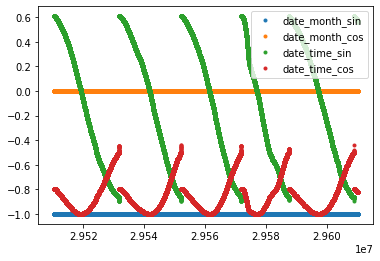

In [75]:
test[["date_month_sin", "date_month_cos","date_time_sin", "date_time_cos"]].head(100000).plot(style=".")

In [78]:
hour_df = test[["date_time_sin", "date_time_cos"]].head(100000)

In [80]:
import matplotlib.pyplot as plt

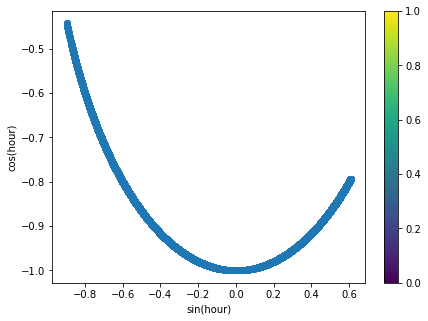

In [82]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["date_time_sin"], hour_df["date_time_cos"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

<AxesSubplot:>

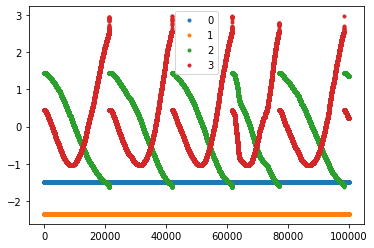

In [77]:
pd.DataFrame(test_trans).head(100000).plot(style=".")

In [71]:
seconds.max()

58500.00000000001

In [72]:
seconds.max() / 3600

16.250000000000004

In [74]:
seconds.min() / 3600

9.5

## Prepare dataset

In [21]:
scaler = MinMaxScaler(feature_range=[-1, 1])

def transform(data: pd.DataFrame) -> pd.DataFrame:

    # # date features
    x = pd.DataFrame(data={"TRADE_PRICE": data["TRADE_PRICE"]}, index=data.index)

    # TODO: speak with caroline
    # x["bid_ex"].replace({0.0:np.NaN}, inplace=True)
    # x["ask_ex"].replace({0.0:np.NaN}, inplace=True)

    # size features
    x["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]
    x["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
    x["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]
    x["depth_ex"] = data["bid_size_ex"] - data["ask_size_ex"]
    
    # classical
    mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
    mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])
    spread_ex = (data["ask_ex"] - data["bid_ex"])
    spread_best = (data["BEST_ASK"] - data["BEST_BID"])
    
    x["prox_ex"] = (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread_ex) 
    x["prox_best"] = (data["TRADE_PRICE"] - mid_best) / (0.5 * spread_best)  

    x["spread_ex"] = spread_ex
    x["spread_best"] = spread_best

    x["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]
    x["price_rel_nbb"] = (data["BEST_ASK"] - data["TRADE_PRICE"]) / (data["BEST_ASK"] - mid_best)
    x["price_rel_nbo"] = (data["TRADE_PRICE"] - data["BEST_BID"]) / (mid_best - data["BEST_BID"])
    
    
    # calculate change
    x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
    x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
    x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
    x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

    # log transformed features
    x[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex",
         ]
     ] = np.log1p(data[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex"
         ]
     ]
     )

    # ["day_vol", "myn"]
    
    # impute with zeros
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(0, inplace=True)

    # scale to [-1, 1]
    try:
        x[x.columns] = scaler.transform(x)
        print("try")
    except NotFittedError as e:
        x[x.columns] = scaler.fit_transform(x)
        print("except")

    x["buy_sell"] = data["buy_sell"]
    return x


In [9]:
X_train = transform(train)
y_train = X_train.buy_sell
X_train.drop(columns=["buy_sell"], inplace=True)

del train

except


In [10]:
X_val = transform(val)
y_val = X_val.buy_sell
X_val.drop(columns=["buy_sell"], inplace=True)
del val

try


## Sanity Check with `catboost`

In [11]:
params = {
        "od_type": "Iter",
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
       "iterations":2000,
       "early_stopping_rounds":100,
       "grow_policy":"Lossguide",
}


weight = np.geomspace(0.001, 1, num=len(y_train))
# keep ordering of data
timestamp = np.linspace(0, 1, len(y_train))

model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train,weight = weight, timestamp=timestamp)
model.fit(train_pool, eval_set=(X_val,y_val))

print(model.score(X_val, y_val))

0.7521829816176018


In [14]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,prox_ex,15.528679
1,ask_size_ex,14.496162
2,bid_size_ex,11.419066
3,prox_best,11.275916
4,price_rel_nbo,10.073817
5,bid_ask_size_ratio_ex,7.577764
6,price_rel_nbb,7.139597
7,rel_bid_size_ex,4.310755
8,spread_ex,3.742201
9,rel_ask_size_ex,2.975100


In [16]:
# 0.7333797810178145 (logs applied) to     x["bid_ask_size_ratio_ex"] x["rel_bid_size_ex"]   x["rel_ask_size_ex"] 
# 0.7331946683482763 (all from above + log returns)
# 0.734859665271541 (all above + compare mids, ask, and bid at exchange with nation wide)
# 0.7349013664773161 (all above + trade_price == bid_ex == ask_ex)
# 0.7351464881990674 (price normed size)
# 0.7352807457396116 (all above +  x["price_rel_nbo"] +  x["price_rel_nbb"])
# 0.74296292 (some removed, see above, max. iterations reached. Actually there is no reason to stop ensemble)
# 0.745053067 convert some ratios to percentages (all other things the same as above)
# 0.7434765583282902 without any scaler, zero imputer, symmetric tree
# 0.7445394305242655 "grow_policy" = "Lossguide" -> trained for 5000 iterations
# 0.7450428963013065 impute with -999 instead of 0 -> trained for 5000 iterations
# 0.7436240382023729 TODO: ask Caroline: What happens with LR if bid_ex = 0 or ask_ex is?   x["bid_ex"].replace({0.0:np.NaN}, inplace=True) and  x["ask_ex"].replace({0.0:np.NaN}, inplace=True)
# 0.7447164063731647 chg from previous trade to successive trade
# 0.7445821488326205 chg from previous trade + no trade indicator
# 0.7476558328290199 "spread" feature ex
# 0.747136093410701 "spread" feature best ex + fixed typo
# 0.7475317463142745 removed features with low importance + impute with -1

## Sanity Check against `lightgbm`

In [17]:
%%script false --no-raise-error
!pip install lightgbm

In [18]:
%%script false --no-raise-error
import lightgbm as lgb

In [19]:
%%script false --no-raise-error
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':None,
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':200,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 42,
                    'eval_metric':'accuracy',
                    "device": "cpu",
                }

In [20]:
%%script false --no-raise-error
# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train,weight=X_train.index.values, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=False)

In [21]:
%%script false --no-raise-error
bst = lgb.LGBMClassifier(**lgb_params)
bst = lgb.train(lgb_params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                early_stopping_rounds=100
)

In [22]:
%%script false --no-raise-error
pred = bst.predict(X_val)
pred = np.rint(pred)
pred[pred==0]=-1
print((y_val == pred).mean())

## Write to file

In [22]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
)
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
)

In [23]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

name = "ise_classic_size_log_normalized"
#dataset = wandb.Artifact(name=name, type="preprocessed_data")

# reset scaler
scaler = MinMaxScaler(feature_range=[-1, 1])

output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/{name}/train_set_60.parquet"
)
train = transform(train)
train.to_parquet(output_path)
#dataset.add_reference(output_path)

del train
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/{name}/val_set_20.parquet"
)
val = transform(val)
val.to_parquet(output_path)
#dataset.add_reference(output_path)

del val
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/{name}/test_set_20.parquet"
)
test = transform(test)
test.to_parquet(output_path)
#dataset.add_reference(output_path)

except
try
try


In [24]:
test.describe()

,TRADE_PRICE,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,depth_ex,prox_ex,prox_best,spread_ex,spread_best,bid_ask_ratio_ex,...,BEST_ASK,BEST_BID,price_all_lag,price_all_lead,price_ex_lag,price_ex_lead,TRADE_SIZE,bid_size_ex,ask_size_ex,buy_sell
count,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,...,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06,9.861576e+06
mean,-7.061342e-01,-9.998360e-01,-9.998290e-01,-9.998783e-01,-1.517021e-04,-4.496103e-01,-2.217283e-01,-3.360071e-01,-9.974931e-01,-7.037069e-01,...,-8.189535e-01,-7.144768e-01,-7.731023e-01,-8.203375e-01,-7.321574e-01,-7.479942e-01,-8.128382e-01,-4.204213e-01,-3.656733e-01,-2.805495e-02
std,2.711683e-01,1.158564e-03,1.354047e-03,8.864031e-04,3.358728e-03,6.287550e-04,7.700381e-04,6.190585e-03,7.246308e-06,1.178656e-01,...,1.602128e-01,2.718154e-01,2.112202e-01,1.696631e-01,2.708560e-01,2.639858e-01,1.995284e-01,3.001729e-01,2.637453e-01,9.996064e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.027665e-01,-5.057553e-01,-3.200000e-01,-1.061782e+00,-9.978192e-01,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-9.195079e-01,-9.999950e-01,-9.999933e-01,-9.999936e-01,-4.050061e-04,-4.499189e-01,-2.219634e-01,-3.387931e-01,-9.974964e-01,-7.333333e-01,...,-9.448681e-01,-9.294147e-01,-9.397130e-01,-9.544227e-01,-9.518099e-01,-9.648794e-01,-1.000000e+00,-5.834429e-01,-5.544227e-01,-1.000000e+00
50%,-7.777990e-01,-9.999808e-01,-9.999701e-01,-9.999773e-01,-5.000075e-06,-4.495944e-01,-2.217390e-01,-3.382184e-01,-9.974957e-01,-6.525424e-01,...,-8.607004e-01,-7.878170e-01,-8.287887e-01,-8.662185e-01,-8.065964e-01,-8.251519e-01,-8.643808e-01,-4.034553e-01,-3.925944e-01,-1.000000e+00
75%,-5.676084e-01,-9.999556e-01,-9.998640e-01,-9.998918e-01,2.650040e-04,-4.493566e-01,-2.215071e-01,-3.363218e-01,-9.974932e-01,-6.220183e-01,...,-7.362892e-01,-5.769865e-01,-6.658070e-01,-7.341432e-01,-5.959212e-01,-6.147051e-01,-6.664538e-01,-2.222069e-01,-1.915243e-01,1.000000e+00
max,1.096489e+00,-8.631786e-01,-6.186268e-02,-3.209091e-01,1.369371e-01,-4.067200e-01,1.930437e-01,1.895977e+00,-9.972290e-01,-1.000000e-01,...,2.405476e-01,1.096545e+00,5.909646e-01,2.682220e-01,1.029699e+00,1.000336e+00,9.747139e-01,6.547516e-01,6.051181e-01,1.000000e+00


In [26]:
test.columns

Index(['TRADE_PRICE', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'depth_ex', 'prox_ex', 'prox_best', 'spread_ex',
       'spread_best', 'bid_ask_ratio_ex', 'price_rel_nbb', 'price_rel_nbo',
       'chg_ex_lead', 'chg_ex_lag', 'chg_all_lead', 'chg_all_lag', 'ask_ex',
       'bid_ex', 'BEST_ASK', 'BEST_BID', 'price_all_lag', 'price_all_lead',
       'price_ex_lag', 'price_ex_lead', 'TRADE_SIZE', 'bid_size_ex',
       'ask_size_ex', 'buy_sell'],
      dtype='object')

In [ ]:
#run.log_artifact(dataset)
#run.finish()